In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict, LeaveOneOut
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [7]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'PCA_Kent'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [8]:
def SVM(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }
    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val
    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        SVR(
            C=4,                # Complexidade do modelo
            epsilon=0.001,        # Epsilon para a perda insensível
            gamma=0.000465,     # Gamma do kernel (inverso do cacheSize em Weka)
            tol=0.0001,            # Tolerância para critério de parada
            cache_size=250007,    # Tamanho do cache
            verbose=False,        # Não exibir mensagens detalhadas
            max_iter=5000
    ))

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df

In [9]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre

=== Training Metrics ===
R²: 0.2343
Correlation coefficient: 0.5385
RMSE: 1.6432
MAE: 1.0544
Relative absolute error: 78.8757
Root relative squared error: 87.5024
Slope: 1.5772
Offset: -7.3601
=== Cross-Validation Metrics ===
R²: -0.0265
Correlation coefficient: 0.0668
RMSE: 1.9026
MAE: 1.3663
Relative absolute error: 102.2148
Root relative squared error: 101.3161
Slope: 0.3302
Offset: 8.0260
=== Validation Metrics ===
R²: -0.3145
Correlation coefficient: 0.3857
RMSE: 1.2530
MAE: 1.0838
Relative absolute error: 113.2777
Root relative squared error: 114.6516
Slope: 0.4441
Offset: 7.7434


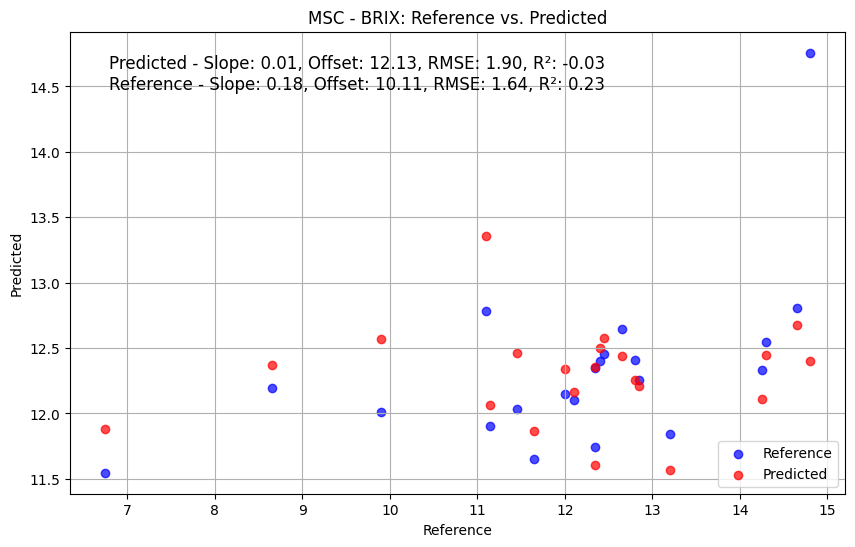

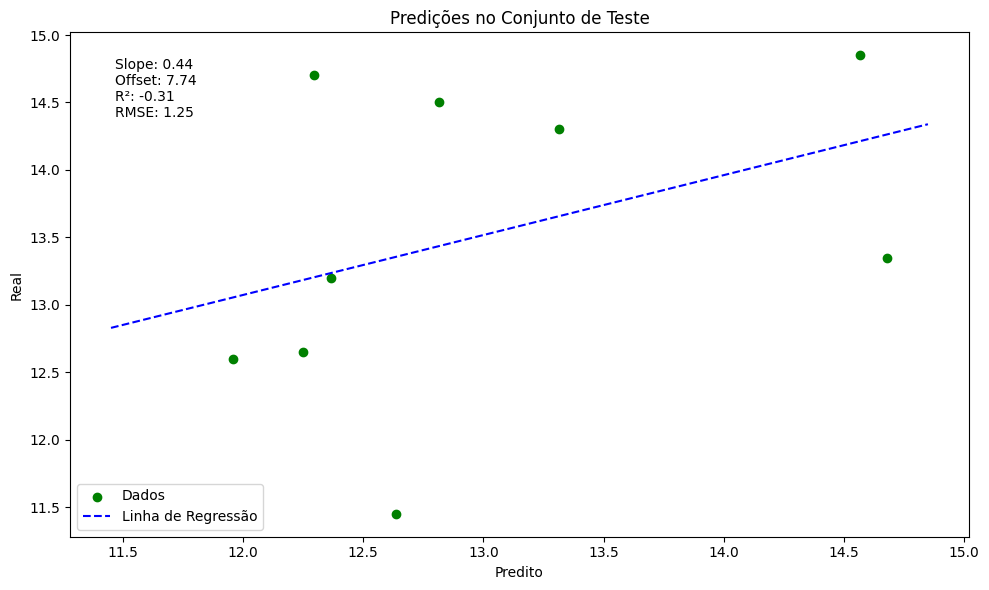

C:\Users\lenau\AppData\Local\Temp\ipykernel_7108\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [10]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['BRIX'].values, df_msc_val.iloc[:, 7:], df_msc_val['BRIX'].values, 'MSC', 'BRIX')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'BRIX')

=== Training Metrics ===
R²: -0.0162
Correlation coefficient: 0.7329
RMSE: 43.4710
MAE: 34.2242
Relative absolute error: 83.8941
Root relative squared error: 100.8064
Slope: 7.8687
Offset: -537.1421
=== Cross-Validation Metrics ===
R²: -0.1394
Correlation coefficient: 0.2634
RMSE: 46.0308
MAE: 36.6091
Relative absolute error: 89.7402
Root relative squared error: 106.7424
Slope: 3.9895
Offset: -248.6213
=== Validation Metrics ===
R²: -1.6783
Correlation coefficient: 0.8062
RMSE: 57.2045
MAE: 52.5295
Relative absolute error: 180.8821
Root relative squared error: 163.6560
Slope: 5.8406
Offset: -399.7219


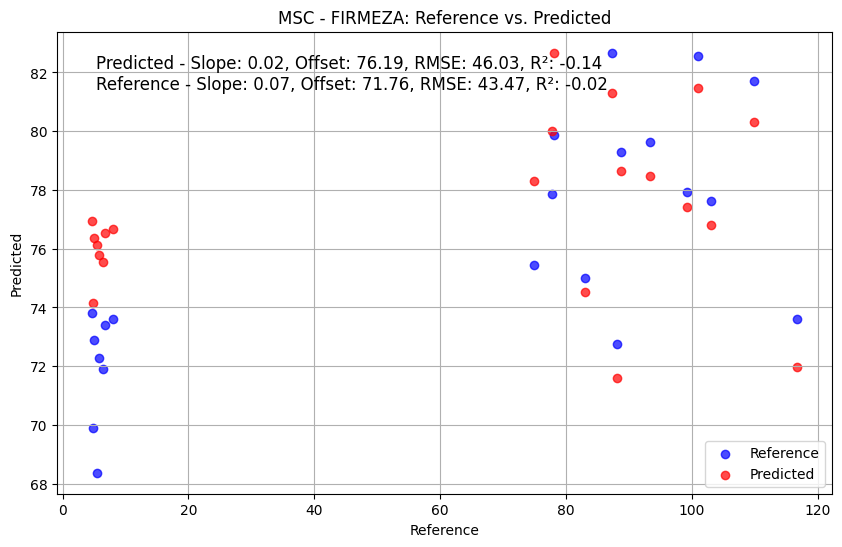

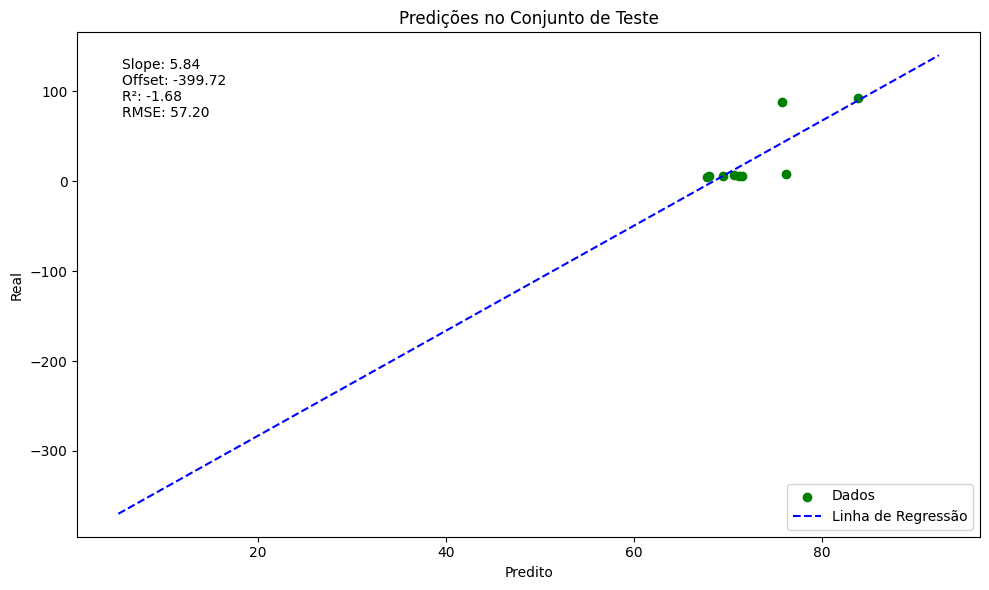

In [11]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['FIRMEZA'].values, df_msc_val.iloc[:, 7:], df_msc_val['FIRMEZA'].values, 'MSC', 'FIRMEZA')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'FIRMEZA')

=== Training Metrics ===
R²: 0.3170
Correlation coefficient: 0.5784
RMSE: 1.4970
MAE: 1.0671
Relative absolute error: 68.0443
Root relative squared error: 82.6446
Slope: 1.0006
Offset: 0.2366


=== Cross-Validation Metrics ===
R²: -0.0153
Correlation coefficient: 0.2674
RMSE: 1.8253
MAE: 1.4951
Relative absolute error: 95.3391
Root relative squared error: 100.7644
Slope: 0.5055
Offset: 3.5578
=== Validation Metrics ===
R²: -1.4558
Correlation coefficient: 0.2457
RMSE: 1.3590
MAE: 1.0996
Relative absolute error: 169.7051
Root relative squared error: 156.7094
Slope: 0.1774
Offset: 5.2902


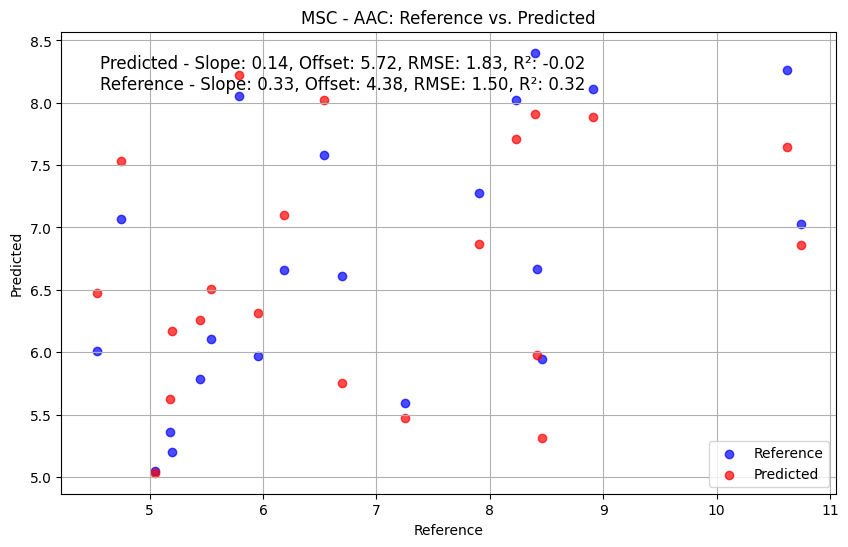

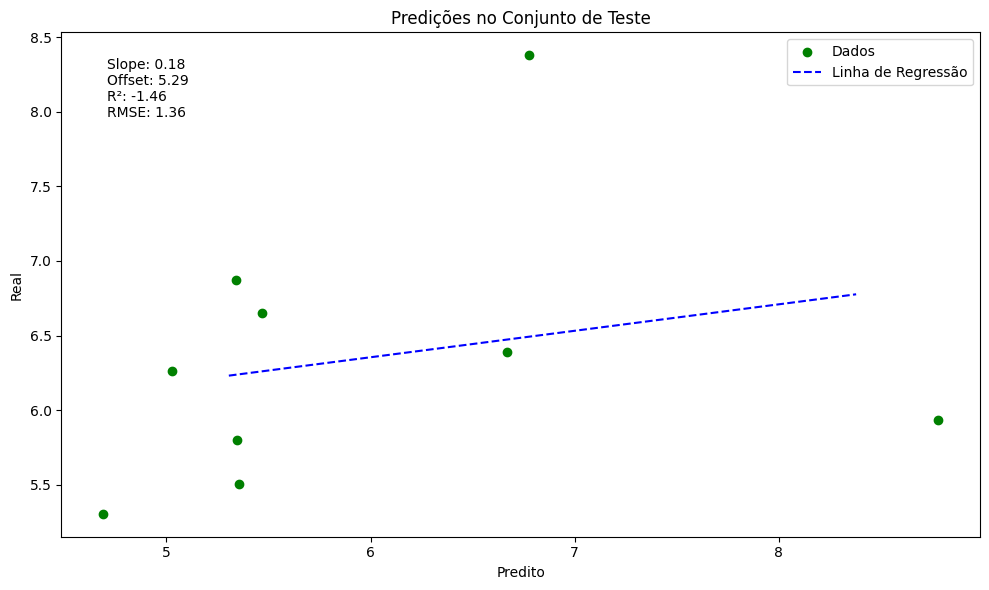

In [12]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['AAC'].values, df_msc_val.iloc[:, 7:], df_msc_val['AAC'].values, 'MSC', 'AAC')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'AAC')

=== Training Metrics ===
R²: 0.7134
Correlation coefficient: 0.8450
RMSE: 0.0754
MAE: 0.0433
Relative absolute error: 35.7885
Root relative squared error: 53.5352
Slope: 1.0254
Offset: -0.0120
=== Cross-Validation Metrics ===
R²: 0.0598
Correlation coefficient: 0.4983
RMSE: 0.1366
MAE: 0.1126
Relative absolute error: 92.9544
Root relative squared error: 96.9628
Slope: 0.5345
Offset: 0.1876
=== Validation Metrics ===
R²: 0.7119
Correlation coefficient: 0.8677
RMSE: 0.0576
MAE: 0.0463
Relative absolute error: 59.5160
Root relative squared error: 53.6749
Slope: 0.8138
Offset: 0.0612


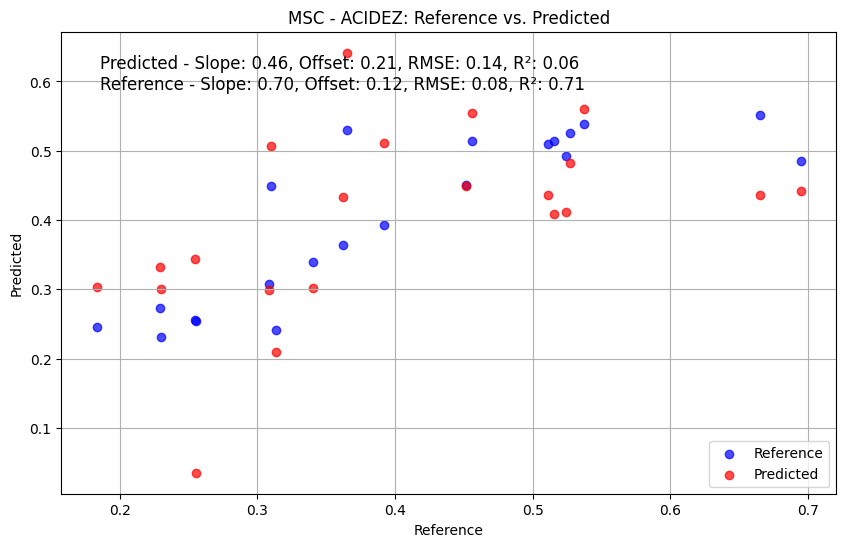

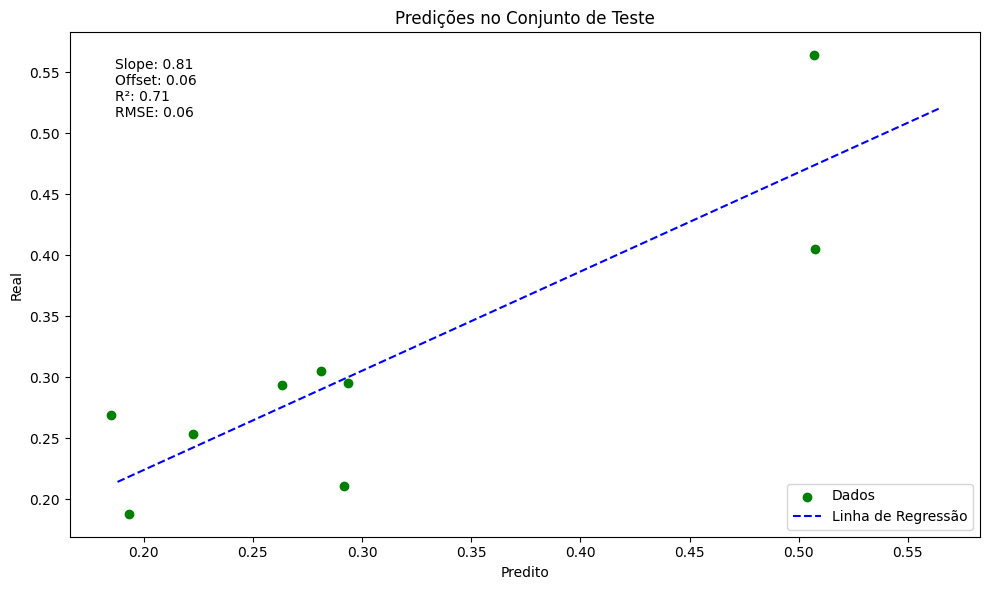

In [13]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['ACIDEZ'].values, df_msc_val.iloc[:, 7:], df_msc_val['ACIDEZ'].values, 'MSC', 'ACIDEZ')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'ACIDEZ')

=== Training Metrics ===
R²: 0.9942
Correlation coefficient: 0.9974
RMSE: 0.0010
MAE: 0.0010
Relative absolute error: 9.5674
Root relative squared error: 7.6476
Slope: 1.0264
Offset: -0.0041
=== Cross-Validation Metrics ===
R²: -0.3734
Correlation coefficient: 0.4383
RMSE: 0.0152
MAE: 0.0125
Relative absolute error: 121.3665
Root relative squared error: 117.1938
Slope: 0.3684
Offset: 0.0977
=== Validation Metrics ===
R²: -4.4103
Correlation coefficient: -0.2192
RMSE: 0.0259
MAE: 0.0188
Relative absolute error: 222.4131
Root relative squared error: 232.6008
Slope: -0.1411
Offset: 0.1808


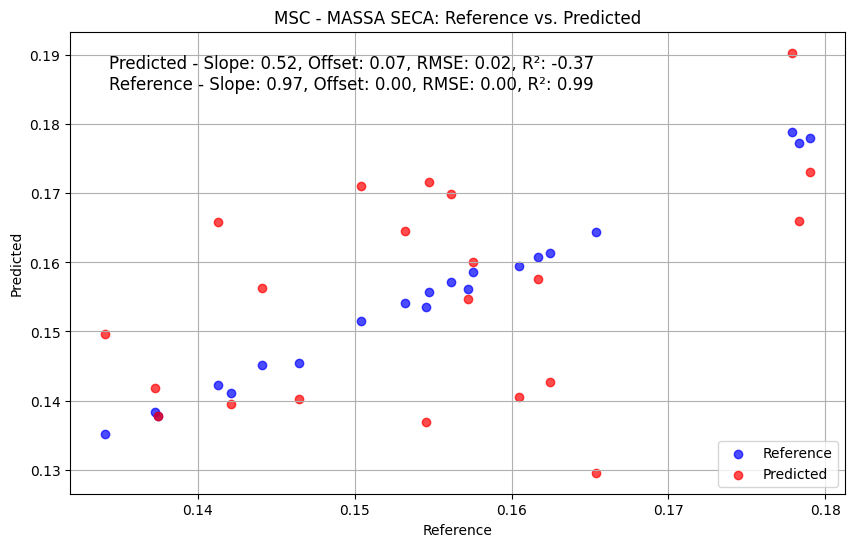

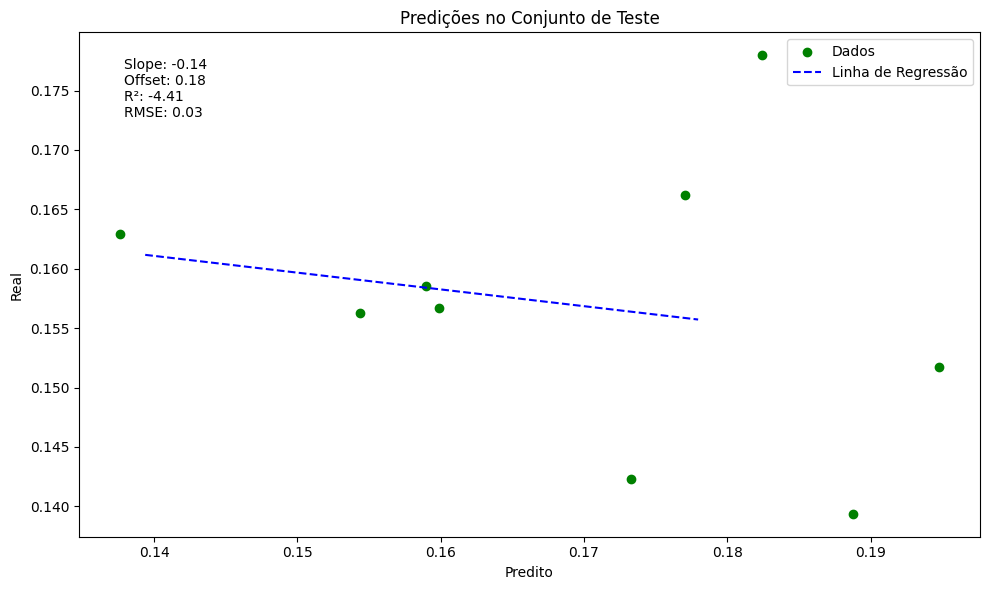

In [14]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 7:], df_msc_cal['MASSA SECA'].values, df_msc_val.iloc[:, 7:], df_msc_val['MASSA SECA'].values, 'MSC', 'MASSA SECA')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'MASSA SECA')

In [15]:
infos_msc.to_excel('plot_infos_SVM_msc.xlsx', index=False)
infos_msc

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,BRIX,Training,0.234334,0.538539,1.643196,1.054358,78.875656,87.502366,1.577181,-7.360090
1,BRIX,Cross-Validation,-0.026496,0.066792,1.902603,1.366340,102.214761,101.316121,0.330154,8.025987
2,BRIX,Validation,-0.314500,0.385714,1.252970,1.083829,113.277659,114.651631,0.444122,7.743406
3,FIRMEZA,Training,-0.016193,0.732947,43.471004,34.224164,83.894062,100.806383,7.868737,-537.142108
4,FIRMEZA,Cross-Validation,-0.139393,0.263430,46.030791,36.609054,89.740168,106.742360,3.989458,-248.621314
5,FIRMEZA,Validation,-1.678327,0.806203,57.204519,52.529489,180.882057,163.655951,5.840607,-399.721860
6,AAC,Training,0.316987,0.578437,1.497042,1.067070,68.044315,82.644617,1.000555,0.236607
7,AAC,Cross-Validation,-0.015347,0.267407,1.825268,1.495106,95.339097,100.764444,0.505528,3.557810
8,AAC,Validation,-1.455784,0.245666,1.358978,1.099573,169.705099,156.709399,0.177405,5.290235
9,ACIDEZ,Training,0.713398,0.844977,0.075430,0.043350,35.788471,53.535184,1.025437,-0.011971


=== Training Metrics ===
R²: 0.2188
Correlation coefficient: 0.6167
RMSE: 1.6718
MAE: 1.1027
Relative absolute error: 81.2087
Root relative squared error: 88.3877
Slope: 2.6490
Offset: -20.5690
=== Cross-Validation Metrics ===
R²: -0.0086
Correlation coefficient: 0.1586
RMSE: 1.8996
MAE: 1.4176
Relative absolute error: 104.4037
Root relative squared error: 100.4283
Slope: 0.5290
Offset: 5.5870
=== Validation Metrics ===
R²: -0.4994
Correlation coefficient: 0.5014
RMSE: 1.3657
MAE: 1.1734
Relative absolute error: 116.0525
Root relative squared error: 122.4481
Slope: 1.4939
Offset: -5.2264


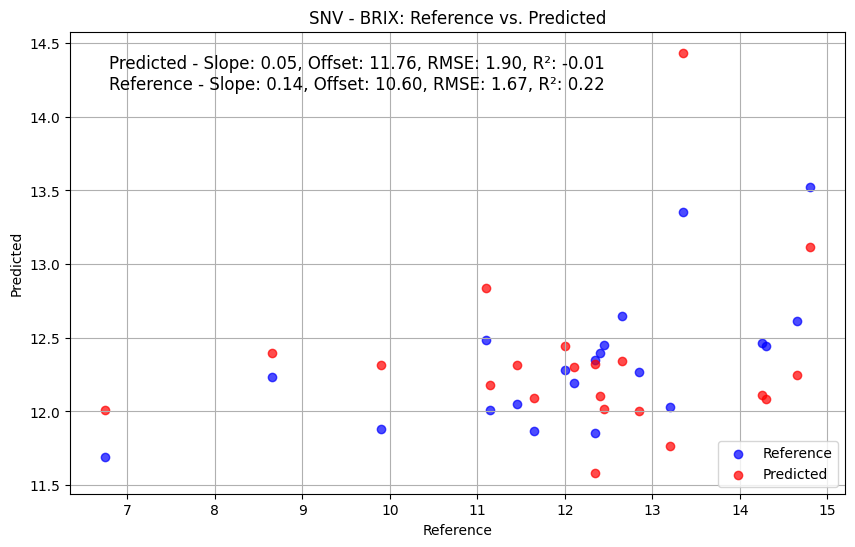

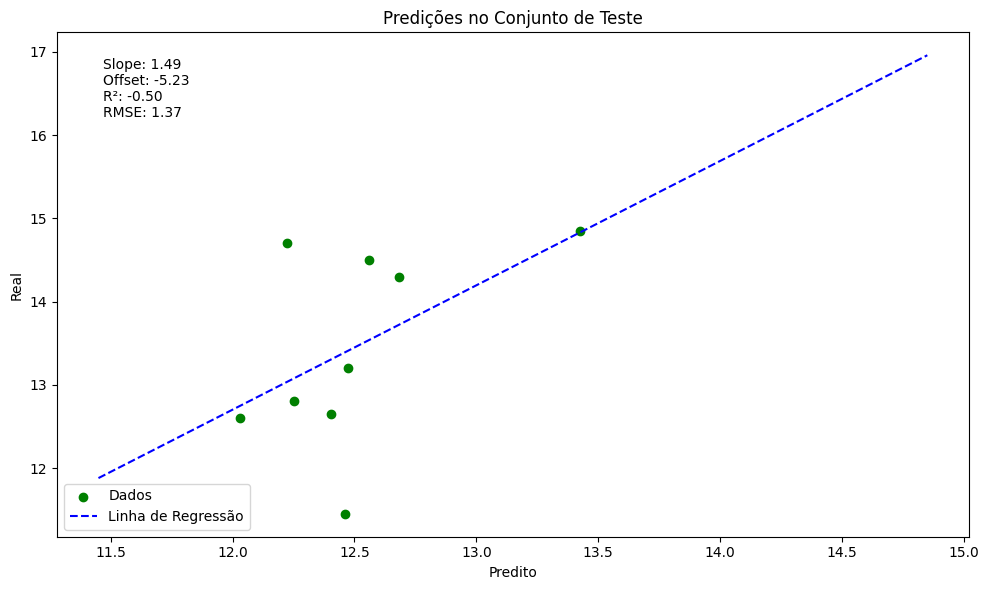

C:\Users\lenau\AppData\Local\Temp\ipykernel_7108\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [16]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['BRIX'].values, df_snv_val.iloc[:, 7:], df_snv_val['BRIX'].values, 'SNV', 'BRIX')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'BRIX')

=== Training Metrics ===
R²: -0.0076
Correlation coefficient: 0.7335
RMSE: 43.2601
MAE: 34.0547
Relative absolute error: 83.5315
Root relative squared error: 100.3783
Slope: 7.3696
Offset: -499.1968
=== Cross-Validation Metrics ===
R²: -0.1262
Correlation coefficient: 0.3362
RMSE: 45.7356
MAE: 36.3969
Relative absolute error: 89.2766
Root relative squared error: 106.1225
Slope: 4.8878
Offset: -317.4800
=== Validation Metrics ===
R²: -1.7506
Correlation coefficient: 0.7534
RMSE: 58.0160
MAE: 53.2344
Relative absolute error: 183.1731
Root relative squared error: 165.8487
Slope: 5.6300
Offset: -388.1434


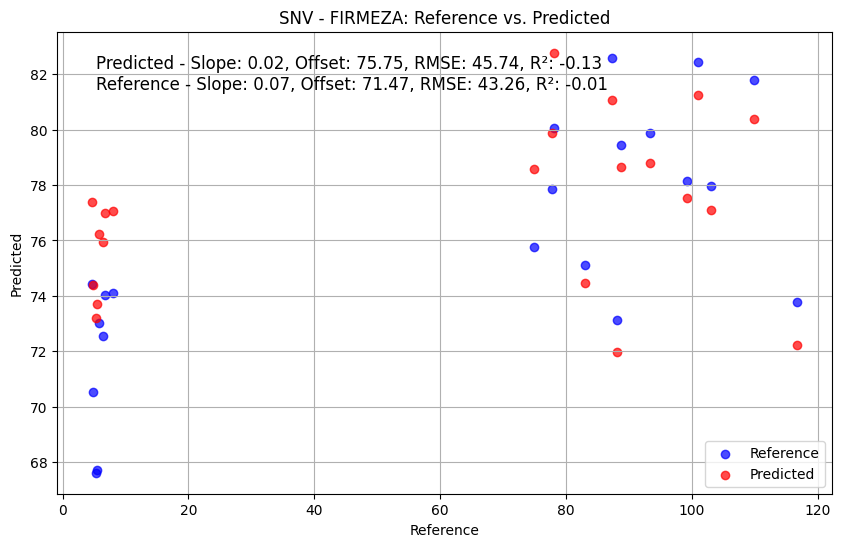

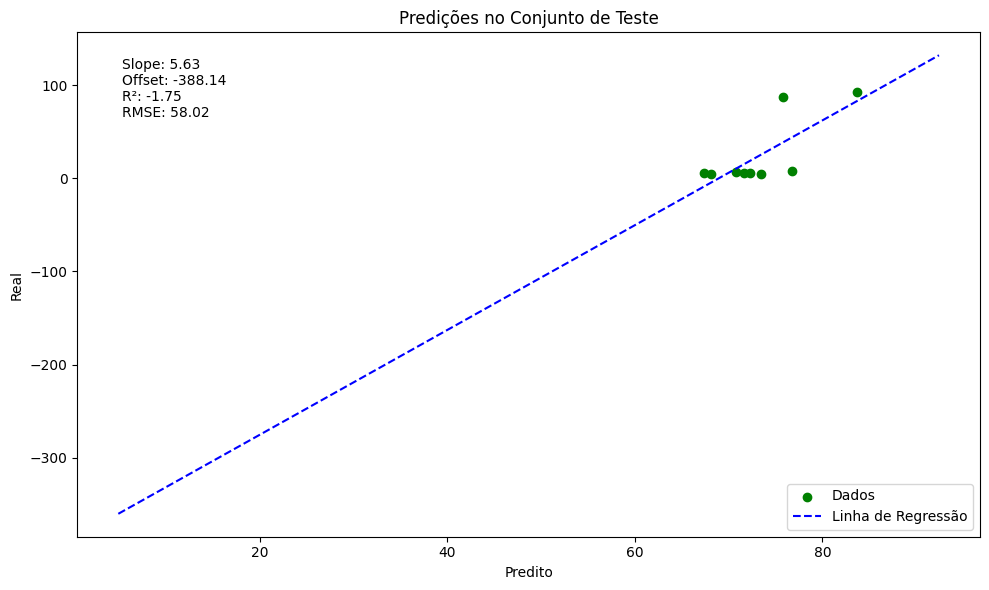

In [17]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['FIRMEZA'].values, df_snv_val.iloc[:, 7:], df_snv_val['FIRMEZA'].values, 'SNV', 'FIRMEZA')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'FIRMEZA')

=== Training Metrics ===
R²: 0.2946
Correlation coefficient: 0.5644
RMSE: 1.4700
MAE: 1.0127
Relative absolute error: 66.7788
Root relative squared error: 83.9893
Slope: 0.9638
Offset: 0.5124
=== Cross-Validation Metrics ===
R²: -0.0544
Correlation coefficient: 0.2341
RMSE: 1.7972
MAE: 1.5041
Relative absolute error: 99.1754
Root relative squared error: 102.6846
Slope: 0.4353
Offset: 4.0543
=== Validation Metrics ===
R²: -0.9849
Correlation coefficient: 0.1509
RMSE: 1.4531
MAE: 1.2505
Relative absolute error: 159.1762
Root relative squared error: 140.8864
Slope: 0.1317
Offset: 5.4045


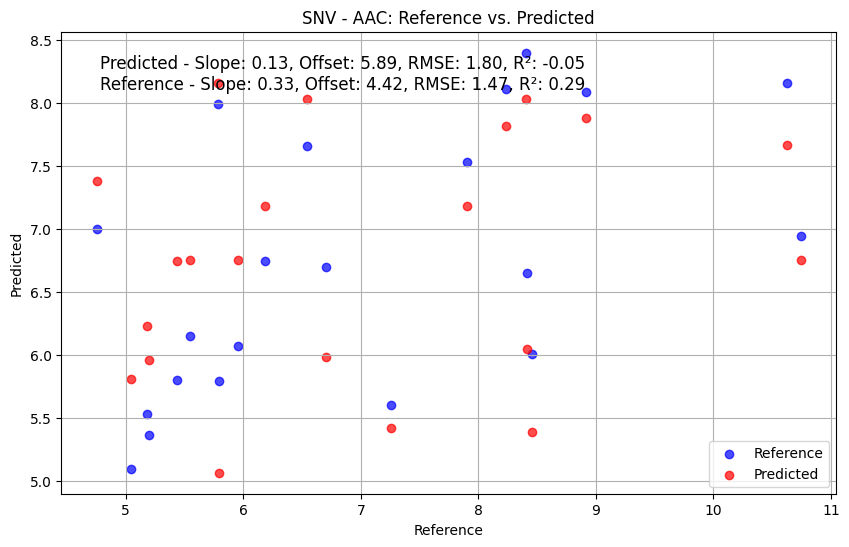

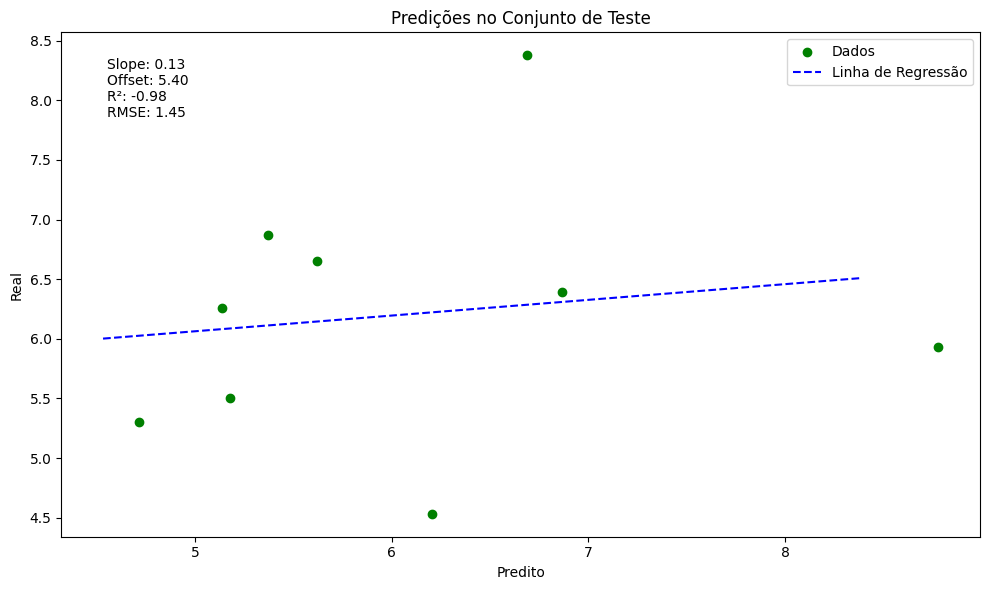

In [18]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['AAC'].values, df_snv_val.iloc[:, 7:], df_snv_val['AAC'].values, 'SNV', 'AAC')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'AAC')

=== Training Metrics ===
R²: 0.6556
Correlation coefficient: 0.8116
RMSE: 0.0833
MAE: 0.0461
Relative absolute error: 37.7948
Root relative squared error: 58.6841
Slope: 1.0628
Offset: -0.0211
=== Cross-Validation Metrics ===
R²: 0.2308
Correlation coefficient: 0.5380
RMSE: 0.1246
MAE: 0.0977
Relative absolute error: 80.1186
Root relative squared error: 87.7068
Slope: 0.6924
Offset: 0.1193
=== Validation Metrics ===
R²: 0.7038
Correlation coefficient: 0.8502
RMSE: 0.0575
MAE: 0.0485
Relative absolute error: 63.1078
Root relative squared error: 54.4221
Slope: 0.8604
Offset: 0.0433


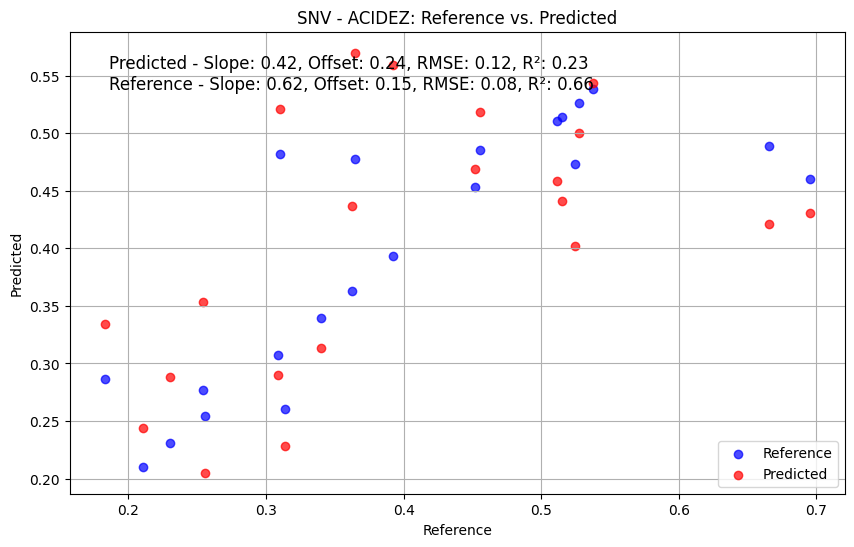

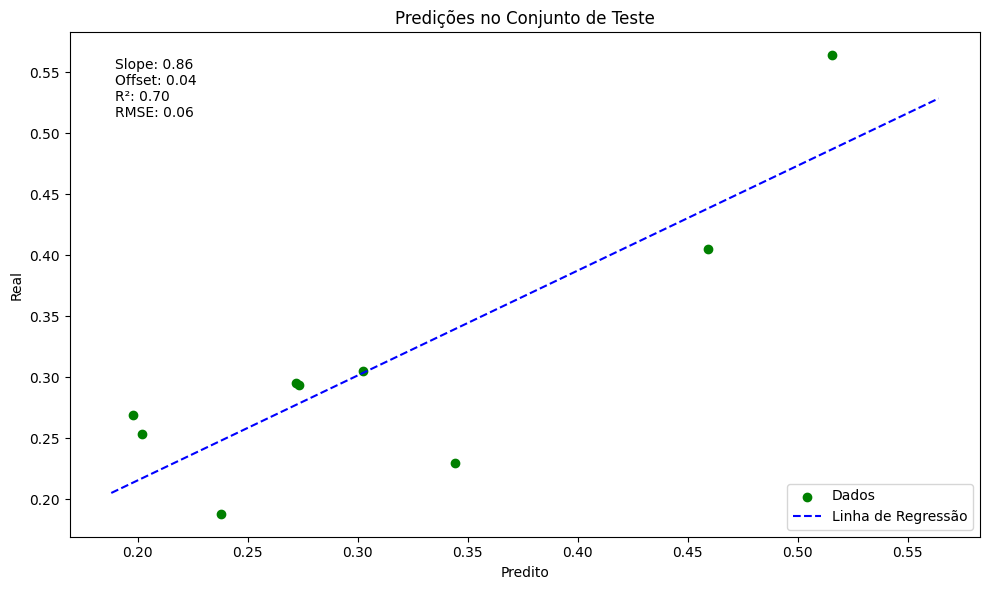

In [19]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['ACIDEZ'].values, df_snv_val.iloc[:, 7:], df_snv_val['ACIDEZ'].values, 'SNV', 'ACIDEZ')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'ACIDEZ')

=== Training Metrics ===
R²: 0.9940
Correlation coefficient: 0.9978
RMSE: 0.0010
MAE: 0.0010
Relative absolute error: 9.6962
Root relative squared error: 7.7653
Slope: 1.0429
Offset: -0.0067
=== Cross-Validation Metrics ===
R²: -1.3042
Correlation coefficient: 0.1383
RMSE: 0.0197
MAE: 0.0147
Relative absolute error: 141.8002
Root relative squared error: 151.7959
Slope: 0.1074
Offset: 0.1380
=== Validation Metrics ===
R²: -4.3172
Correlation coefficient: -0.3967
RMSE: 0.0254
MAE: 0.0181
Relative absolute error: 220.3695
Root relative squared error: 230.5905
Slope: -0.2400
Offset: 0.1963


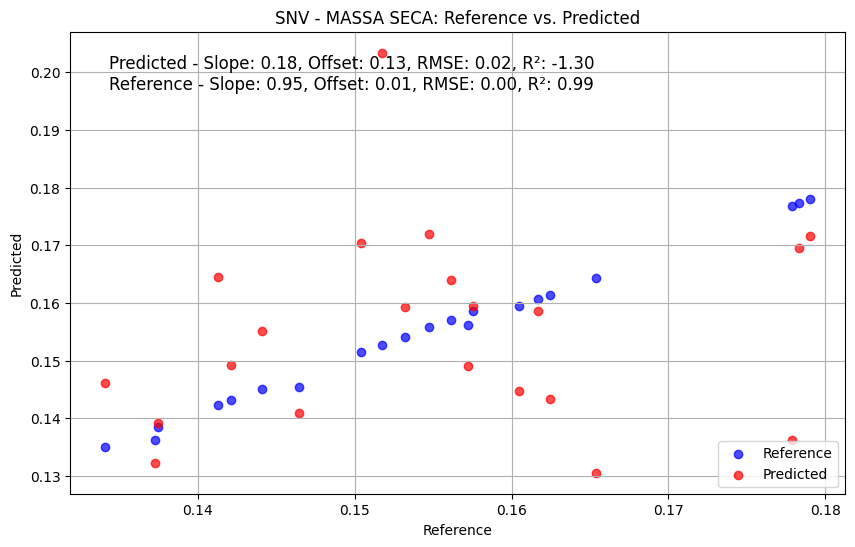

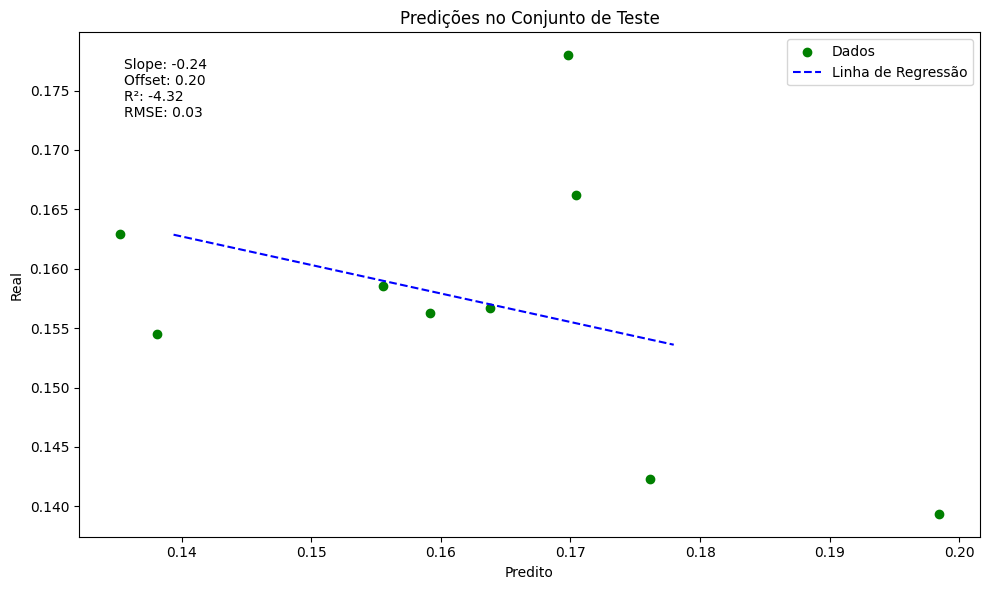

In [20]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 7:], df_snv_cal['MASSA SECA'].values, df_snv_val.iloc[:, 7:], df_snv_val['MASSA SECA'].values, 'SNV', 'MASSA SECA')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'MASSA SECA')

In [21]:
infos_snv.to_excel('plot_infos_SVM_snv.xlsx', index=False)
infos_snv

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,BRIX,Training,0.218762,0.616719,1.671812,1.102670,81.208653,88.387667,2.648957,-20.569031
1,BRIX,Cross-Validation,-0.008584,0.158561,1.899554,1.417618,104.403721,100.428267,0.529012,5.587038
2,BRIX,Validation,-0.499354,0.501373,1.365661,1.173420,116.052480,122.448101,1.493934,-5.226423
3,FIRMEZA,Training,-0.007581,0.733472,43.260072,34.054716,83.531508,100.378331,7.369596,-499.196805
4,FIRMEZA,Cross-Validation,-0.126199,0.336202,45.735642,36.396909,89.276583,106.122511,4.887784,-317.479994
5,FIRMEZA,Validation,-1.750578,0.753368,58.016019,53.234387,183.173057,165.848677,5.630036,-388.143414
6,AAC,Training,0.294579,0.564447,1.469997,1.012746,66.778841,83.989315,0.963820,0.512390
7,AAC,Cross-Validation,-0.054413,0.234099,1.797205,1.504061,99.175396,102.684601,0.435317,4.054337
8,AAC,Validation,-0.984898,0.150899,1.453095,1.250486,159.176189,140.886400,0.131745,5.404497
9,ACIDEZ,Training,0.655617,0.811554,0.083347,0.046066,37.794777,58.684141,1.062756,-0.021121


=== Training Metrics ===
R²: 0.3393
Correlation coefficient: 0.6444
RMSE: 1.4876
MAE: 0.8078
Relative absolute error: 62.2919
Root relative squared error: 81.2813
Slope: 1.3173
Offset: -4.3666
=== Cross-Validation Metrics ===
R²: 0.1338
Correlation coefficient: 0.4045
RMSE: 1.7033
MAE: 1.1610
Relative absolute error: 89.5235
Root relative squared error: 93.0702
Slope: 1.0870
Offset: -1.3843
=== Validation Metrics ===
R²: -0.9924
Correlation coefficient: 0.1099
RMSE: 1.5704
MAE: 1.3319
Relative absolute error: 133.6895
Root relative squared error: 141.1517
Slope: 0.1007
Offset: 12.2833


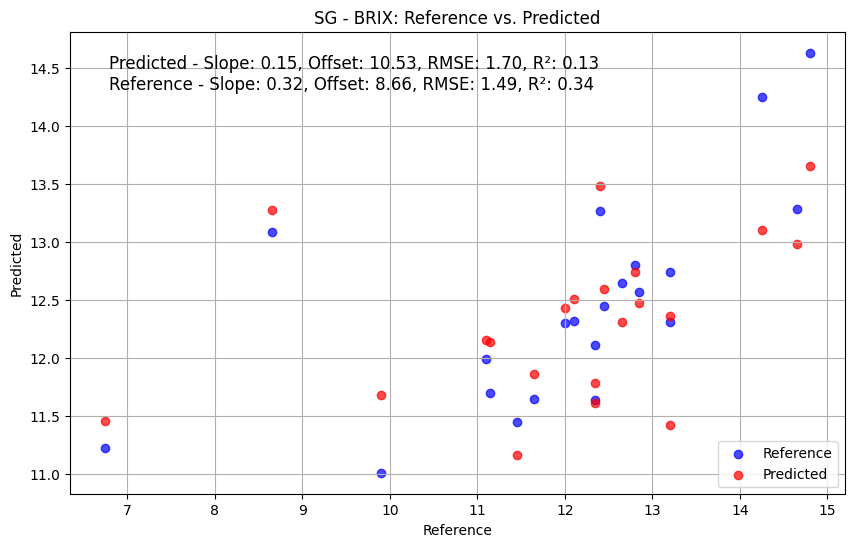

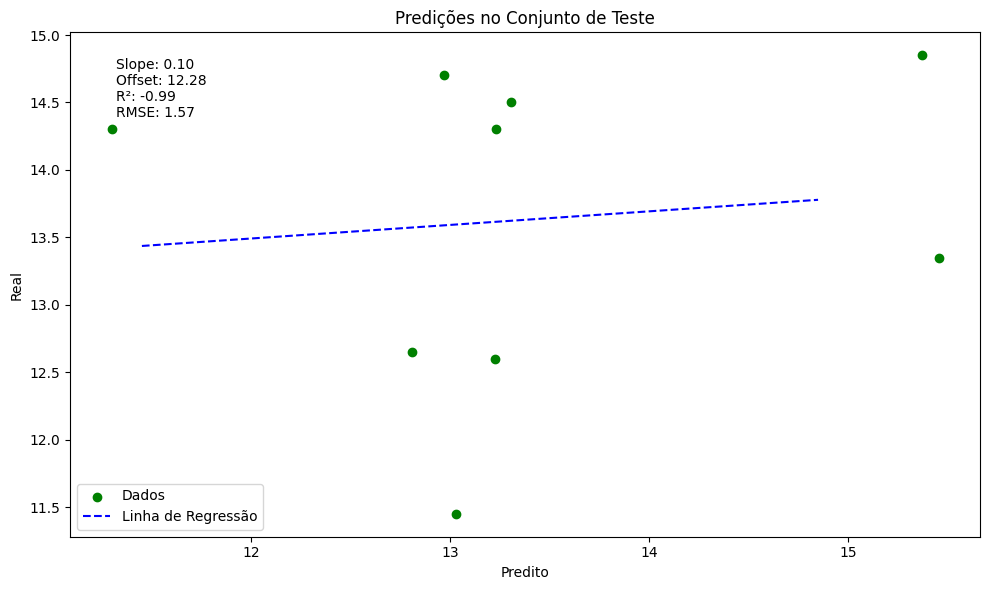

C:\Users\lenau\AppData\Local\Temp\ipykernel_7108\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [22]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['BRIX'].values, df_sg_val.iloc[:, 7:], df_sg_val['BRIX'].values, 'SG', 'BRIX')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'BRIX')

=== Training Metrics ===
R²: -0.1268
Correlation coefficient: 0.6728
RMSE: 44.5654
MAE: 31.9359
Relative absolute error: 82.9572
Root relative squared error: 106.1494
Slope: 9.7010
Offset: -741.7428
=== Cross-Validation Metrics ===
R²: -0.1865
Correlation coefficient: 0.1171
RMSE: 45.7314
MAE: 33.8530
Relative absolute error: 87.9372
Root relative squared error: 108.9267
Slope: 1.9169
Offset: -93.9804
=== Validation Metrics ===
R²: -6.3049
Correlation coefficient: 0.0136
RMSE: 69.3137
MAE: 66.1725
Relative absolute error: 410.7493
Root relative squared error: 270.2763
Slope: 0.1550
Offset: 2.8670


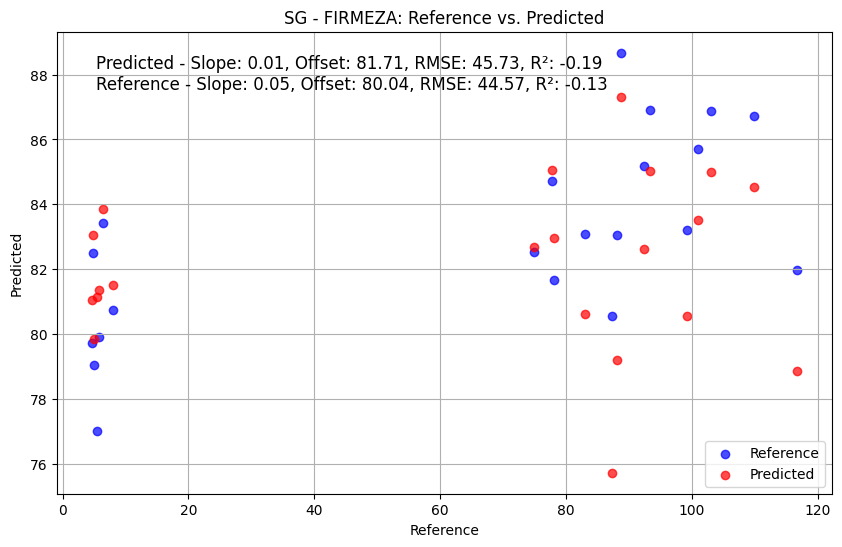

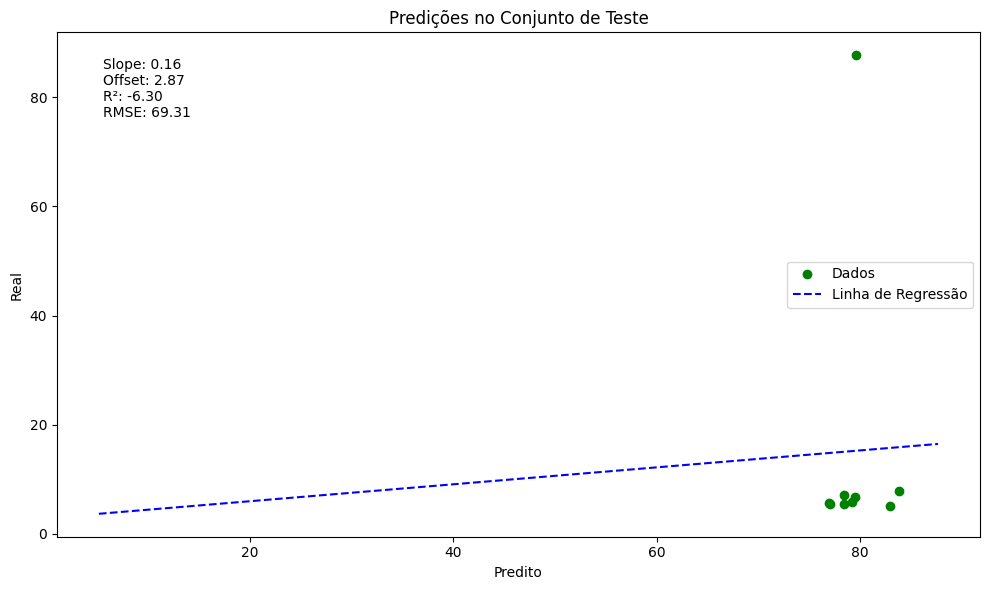

In [23]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['FIRMEZA'].values, df_sg_val.iloc[:, 7:], df_sg_val['FIRMEZA'].values, 'SG', 'FIRMEZA')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'FIRMEZA')

=== Training Metrics ===
R²: 0.2293
Correlation coefficient: 0.5164
RMSE: 1.5757
MAE: 1.1779
Relative absolute error: 76.0890
Root relative squared error: 87.7889
Slope: 1.2805
Offset: -1.5945
=== Cross-Validation Metrics ===
R²: -0.1247
Correlation coefficient: 0.0467
RMSE: 1.9035
MAE: 1.5968
Relative absolute error: 103.1519
Root relative squared error: 106.0519
Slope: 0.1239
Offset: 6.1335
=== Validation Metrics ===
R²: -0.6750
Correlation coefficient: -0.0310
RMSE: 1.1728
MAE: 0.9885
Relative absolute error: 141.8654
Root relative squared error: 129.4234
Slope: -0.0484
Offset: 6.5725


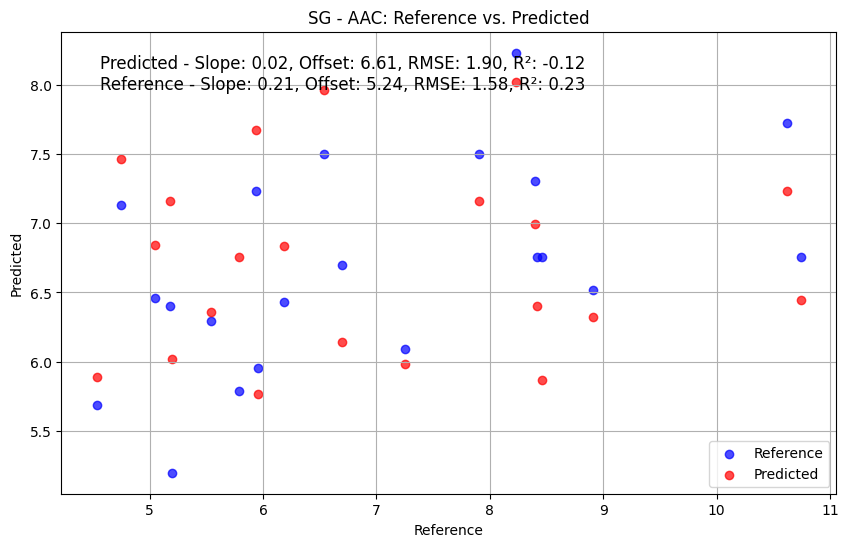

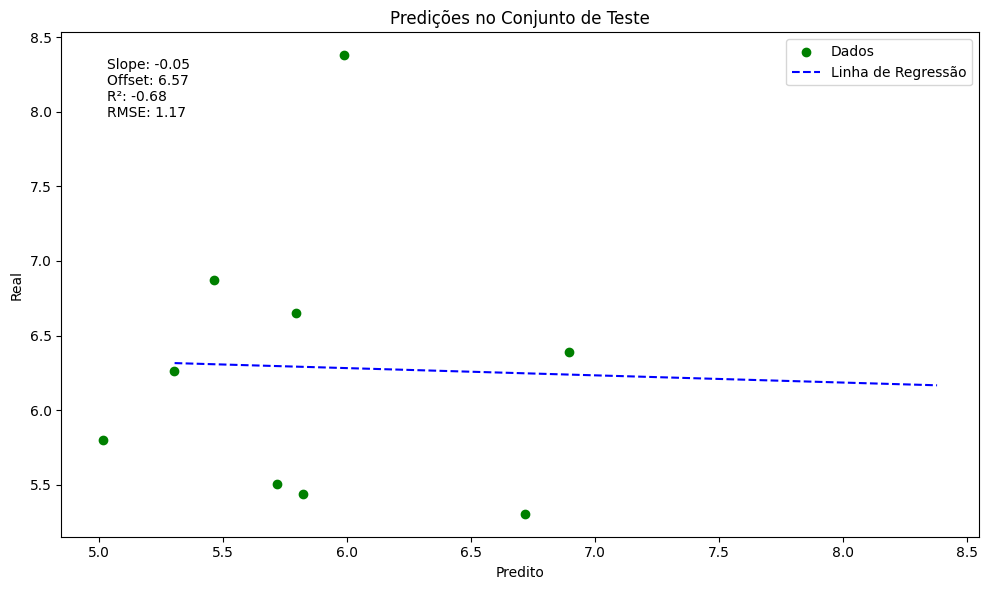

In [24]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['AAC'].values, df_sg_val.iloc[:, 7:], df_sg_val['AAC'].values, 'SG', 'AAC')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'AAC')

=== Training Metrics ===
R²: 0.5836
Correlation coefficient: 0.7660
RMSE: 0.0910
MAE: 0.0455
Relative absolute error: 37.1249
Root relative squared error: 64.5295
Slope: 1.0759
Offset: -0.0290
=== Cross-Validation Metrics ===
R²: -0.2611
Correlation coefficient: 0.3724
RMSE: 0.1583
MAE: 0.1294
Relative absolute error: 105.5268
Root relative squared error: 112.2989
Slope: 0.3709
Offset: 0.2631
=== Validation Metrics ===
R²: 0.4309
Correlation coefficient: 0.8198
RMSE: 0.0444
MAE: 0.0330
Relative absolute error: 74.5810
Root relative squared error: 75.4376
Slope: 0.6257
Offset: 0.1039


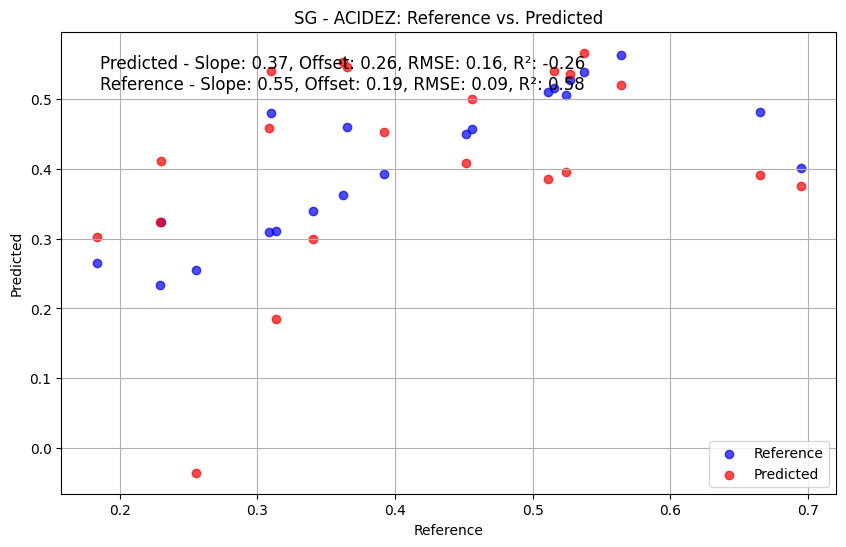

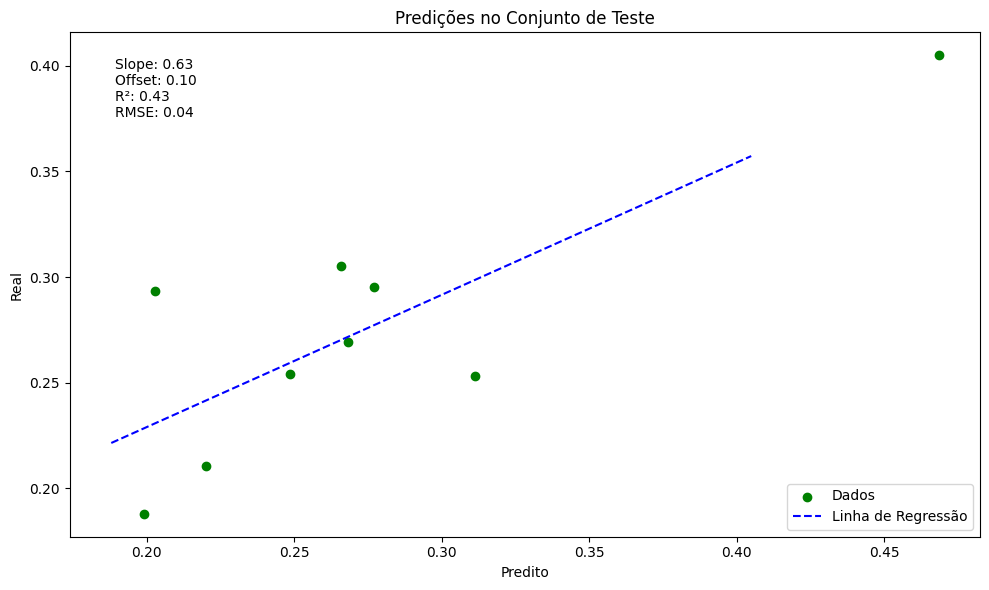

In [25]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['ACIDEZ'].values, df_sg_val.iloc[:, 7:], df_sg_val['ACIDEZ'].values, 'SG', 'ACIDEZ')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'ACIDEZ')

=== Training Metrics ===
R²: 0.8956
Correlation coefficient: 0.9482
RMSE: 0.0039
MAE: 0.0020
Relative absolute error: 20.7690
Root relative squared error: 32.3137
Slope: 0.9428
Offset: 0.0087
=== Cross-Validation Metrics ===
R²: -2.0161
Correlation coefficient: 0.3273
RMSE: 0.0209
MAE: 0.0167
Relative absolute error: 174.0934
Root relative squared error: 173.6687
Slope: 0.1838
Offset: 0.1255
=== Validation Metrics ===
R²: -3.5181
Correlation coefficient: 0.2608
RMSE: 0.0276
MAE: 0.0191
Relative absolute error: 183.7884
Root relative squared error: 212.5571
Slope: 0.1787
Offset: 0.1269


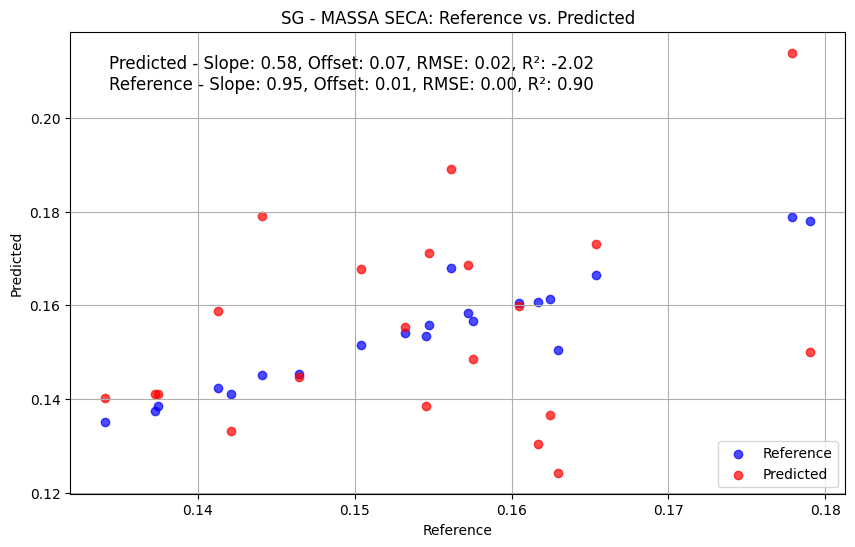

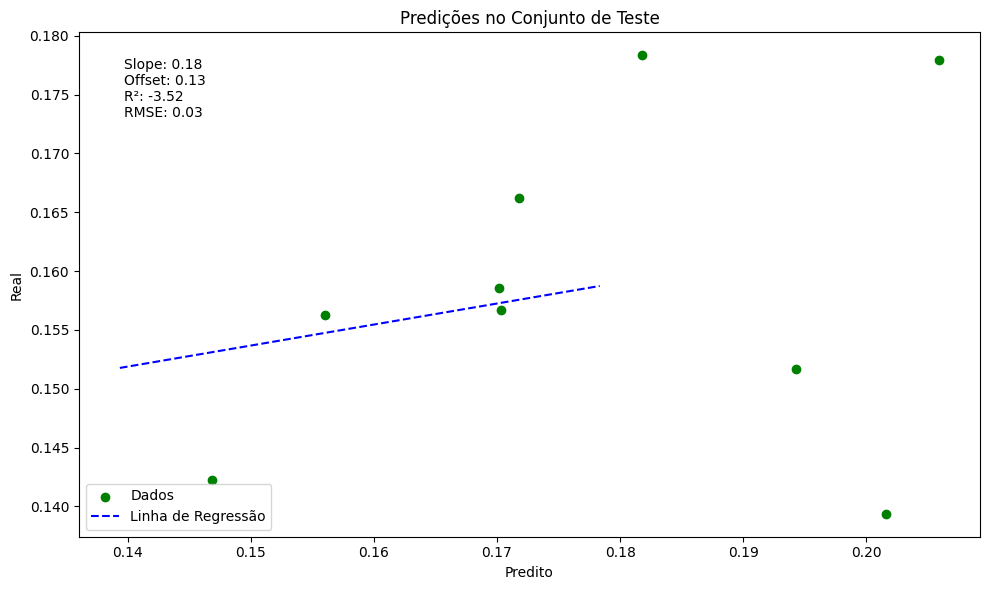

In [26]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 7:], df_sg_cal['MASSA SECA'].values, df_sg_val.iloc[:, 7:], df_sg_val['MASSA SECA'].values, 'SG', 'MASSA SECA')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'MASSA SECA')

In [27]:
infos_sg.to_excel('plot_infos_SVM_sg.xlsx', index=False)
infos_sg

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,BRIX,Training,0.339335,0.644374,1.487551,0.807818,62.291949,81.281313,1.317283,-4.366635
1,BRIX,Cross-Validation,0.133793,0.404508,1.703304,1.160963,89.523494,93.070235,1.086991,-1.384316
2,BRIX,Validation,-0.992381,0.109930,1.570390,1.331943,133.689481,141.151738,0.100668,12.283292
3,FIRMEZA,Training,-0.126770,0.672800,44.565416,31.935892,82.957208,106.149405,9.701026,-741.742773
4,FIRMEZA,Cross-Validation,-0.186503,0.117109,45.731442,33.853022,87.937177,108.926737,1.916938,-93.980436
5,FIRMEZA,Validation,-6.304927,0.013600,69.313668,66.172478,410.749333,270.276277,0.155044,2.867038
6,AAC,Training,0.229311,0.516390,1.575693,1.177868,76.088984,87.788891,1.280549,-1.594529
7,AAC,Cross-Validation,-0.124700,0.046725,1.903488,1.596805,103.151897,106.051858,0.123921,6.133489
8,AAC,Validation,-0.675042,-0.030982,1.172756,0.988481,141.865420,129.423427,-0.048438,6.572509
9,ACIDEZ,Training,0.583595,0.766021,0.090957,0.045509,37.124928,64.529463,1.075867,-0.029047
